# Exploring and Analyzing Text Data Assignment 

In [1]:
# !pip install wordcloud
# !pip install yellowbrick

In [2]:
import spacy
import string
import pandas as pd
from nltk import pos_tag
from nltk.text import Text
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

### Read the CNN Lite plain text file articles into a corpus using the NLTK's PlaintextCorpusReader.

In [3]:
PATH = 'cnn_lite/'
DOC_PATTERN = r'articles_text.*\.p'
corpus = PlaintextCorpusReader(PATH, DOC_PATTERN)

### Iterate through the fileids in the corpus, extract the raw text of each document, and store them in a list.

In [4]:
docs = [corpus.raw(fileid) for fileid in corpus.fileids()]

### Write a function that calculates the following statistics for a document and returns them as a list.

- Number of sentences
- Number of tokens
- Number of words (no stop words or punctuation)
- Number of unique words (vocabulary)
- Number of unique named entities (excluding numbers, dates, times, and currency types)
- Average sentence length
- Average word length
- Lexical diversity

In [5]:
def text_stats(doc):
    sents = sent_tokenize(doc)
    tokens = word_tokenize(doc)
    
    words = []
    for token in tokens:
        if token.lower() not in stopwords.words('english') and token.lower().isalpha():
            words.append(token.lower())
    
    num_sents = len(sents)
    num_tokens = len(tokens)
    num_words = len(words)
    
    entities = []
    num_types = ['DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']
    
    spacy_doc = nlp(doc)
    for entity in spacy_doc.ents:
        if entity.label_ not in num_types:
            entities.append(entity)
            
    num_entities = len(set(entities))
    
    sent_len = num_words / num_sents
    word_len = sum([len(word) for word in words]) / num_words
    lex_div = len(set(words)) / num_words
    
    stats = [num_sents, num_tokens, num_words, num_entities, sent_len, word_len, lex_div]
    
    return stats

### Iterate through all the documents, calculate these statistics for each one, and store all the results in a Pandas data frame.

In [6]:
stats_list = []
for doc in docs:
    stats_list.append(text_stats(doc))

In [7]:
stats_df = pd.DataFrame(stats_list, columns=['Sentences', 'Tokens', 'Words', 'Entities', 
                                       'Sentence Length', 'Word Length', 'Lexical Diversity'])
stats_df

,Sentences,Tokens,Words,Entities,Sentence Length,Word Length,Lexical Diversity
0,7,232,95,12,13.571429,5.736842,0.810526
1,15,676,329,51,21.933333,6.419453,0.720365
2,13,546,225,20,17.307692,6.013333,0.688889
3,29,1020,453,75,15.620690,6.218543,0.653422
4,68,1990,885,174,13.014706,6.757062,0.620339
5,47,1255,501,61,10.659574,6.209581,0.690619
6,68,1781,789,126,11.602941,6.135615,0.599493
7,32,824,389,56,12.156250,6.125964,0.658098
8,13,541,269,41,20.692308,6.721190,0.661710
9,8,265,116,14,14.500000,5.465517,0.732759


### Summarize these statistics for the entire corpus by calling the Pandas `describe` method.

In [8]:
stats_df.describe()

,Sentences,Tokens,Words,Entities,Sentence Length,Word Length,Lexical Diversity
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,30.500000,935.857143,431.285714,62.000000,15.119952,6.293546,0.684106
std,21.302763,558.427580,258.513630,47.979162,3.681468,0.421883,0.057325
min,7.000000,232.000000,95.000000,12.000000,10.416667,5.465517,0.599493
25%,13.000000,542.250000,236.000000,25.250000,12.370864,6.126748,0.654591
50%,29.000000,922.000000,421.000000,52.500000,14.203704,6.214062,0.667739
75%,43.250000,1244.000000,592.500000,71.500000,17.187666,6.558144,0.712928
max,68.000000,1990.000000,885.000000,174.000000,21.933333,7.065246,0.810526


### Choose a document from the list of documents you created earlier and generate a frequency distribution bar chart for it showing which terms appear most frequently in the text.

In [9]:
cleaned = []
tokens = word_tokenize(docs[3])
for token in tokens:
    if token.lower() not in stopwords.words('english') and token.lower().isalpha():
        cleaned.append(token.lower())

In [10]:
fdist = FreqDist(cleaned)
fdist_df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()

fdist_df.columns = ['Term', 'Freq']
fdist_df = fdist_df[fdist_df['Freq'] > 2]
fdist_df = fdist_df.sort_values('Freq', ascending=False)
fdist_df.head()

,Term,Freq
30,bloomberg,9
26,new,8
4,run,8
188,biden,6
55,clinton,6


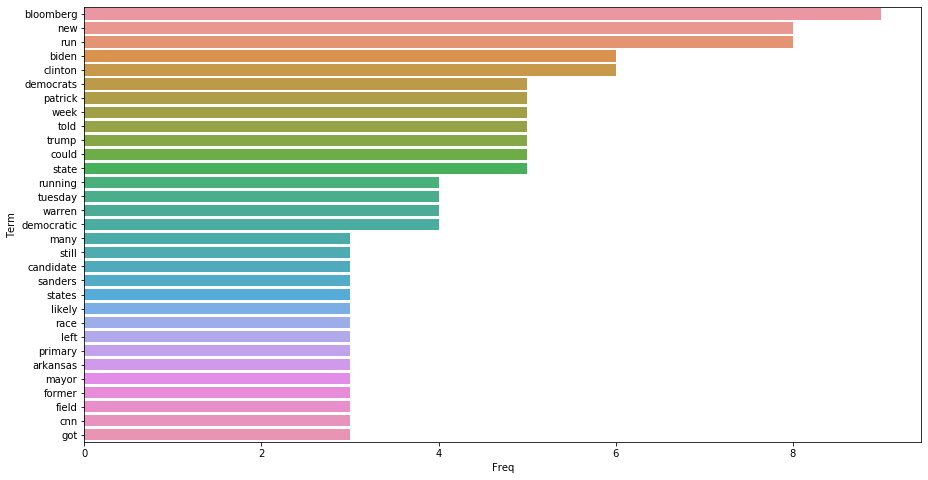

In [11]:
plt.figure(figsize=(15, 8))
sns.barplot(data=fdist_df, x='Freq', y='Term')
plt.show()

### Generate a word cloud visualization for the same document for which you generated the frequency distribution.

In [12]:
def word_cloud(text, colormap='tab10', background_color='white'):
    cloud = WordCloud(width=1600, height=800, stopwords=STOPWORDS,
                      colormap=colormap, 
                      background_color=background_color).generate(text)
    
    plt.figure(figsize=(12,10))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

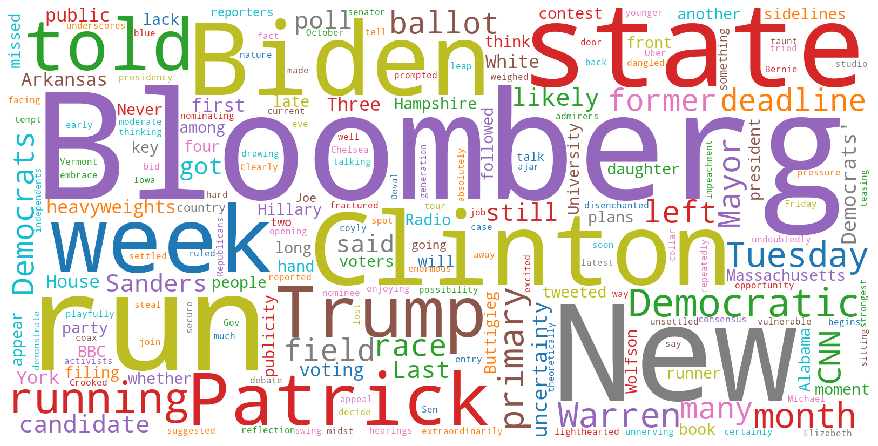

In [13]:
word_cloud(docs[3])

### Choose a different article (preferably one that references several named entities) and create a dispersion plot that shows the occurrence of those entities throughout the document.

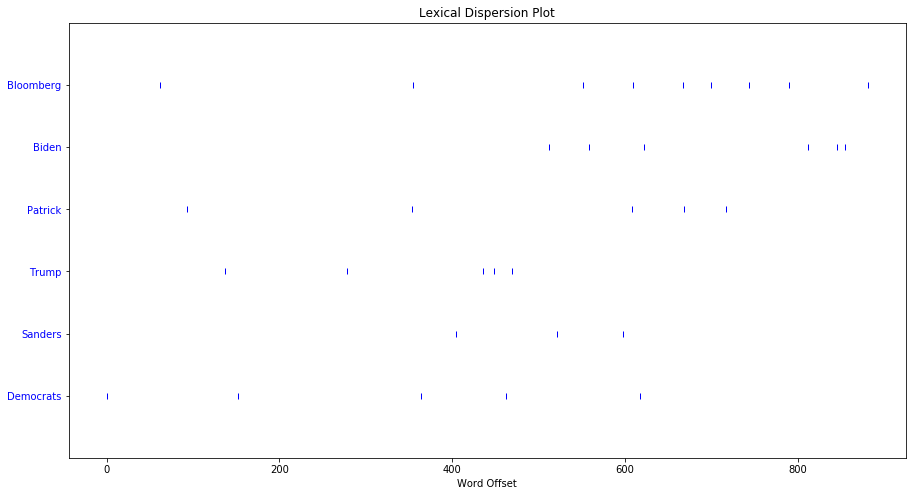

In [14]:
tokenized = word_tokenize(docs[3])
figures = ['Bloomberg', 'Biden', 'Patrick', 'Trump', 'Sanders', 'Democrats']

plt.figure(figsize=(15, 8))
Text(tokenized).dispersion_plot(figures)

### Choose another article and generate a POS visualization highlighting the parts of speech for tokens in the article.

In [15]:
from yellowbrick.text.postag import PosTagVisualizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag, word_tokenize
import os

In [17]:
tag_map = {
    'NN'   : 'green',
    'NNS'  : 'green',
    'NNP'  : 'green',
    'NNPS' : 'green',
    'VB'   : 'blue',
    'VBD'  : 'blue',
    'VBG'  : 'blue',
    'VBN'  : 'blue',
    'VBP'  : 'blue',
    'VBZ'  : 'blue',
    'JJ'   : 'red',
    'JJR'  : 'red',
    'JJS'  : 'red',
    'RB'   : 'cyan',
    'RBR'  : 'cyan',
    'RBS'  : 'cyan',
    'IN'   : 'darkwhite',
    'POS'  : 'darkyellow',
    'PRP$' : 'magenta',
    'PRP$' : 'magenta',
    'DT'   : 'black',
    'CC'   : 'black',
    'CD'   : 'black',
    'WDT'  : 'black',
    'WP'   : 'black',
    'WP$'  : 'black',
    'WRB'  : 'black',
    'EX'   : 'yellow',
    'FW'   : 'yellow',
    'LS'   : 'yellow',
    'MD'   : 'yellow',
    'PDT'  : 'yellow',
    'RP'   : 'yellow',
    'SYM'  : 'yellow',
    'TO'   : 'yellow',
}

In [18]:
COLORS = {
    'white'      : "\033[0;37m{}\033[0m",
    'yellow'     : "\033[0;33m{}\033[0m",
    'green'      : "\033[0;32m{}\033[0m",
    'blue'       : "\033[0;34m{}\033[0m",
    'cyan'       : "\033[0;36m{}\033[0m",
    'red'        : "\033[0;31m{}\033[0m",
    'magenta'    : "\033[0;35m{}\033[0m",
    'black'      : "\033[0;30m{}\033[0m",
    'darkwhite'  : "\033[1;37m{}\033[0m",
    'darkyellow' : "\033[1;33m{}\033[0m",
    'darkgreen'  : "\033[1;32m{}\033[0m",
    'darkblue'   : "\033[1;34m{}\033[0m",
    'darkcyan'   : "\033[1;36m{}\033[0m",
    'darkred'    : "\033[1;31m{}\033[0m",
    'darkmagenta': "\033[1;35m{}\033[0m",
    'darkblack'  : "\033[1;30m{}\033[0m",
    'off'        : "\033[0;0m{}\033[0m"
}

In [19]:
def colored(text, color=None):
    """
    Colorize text
    """
    if os.getenv('ANSI_COLORS_DISABLED') is None:
        if color is not None:
            text = COLORS[color].format(text)
    return text

In [20]:
tokens = word_tokenize(docs[3])
# Part of speech tag the text and map to Treebank-tagged colors
tagged = [
  (tag_map.get(tag),token)
  for token, tag in pos_tag(tokens)
]
print(' '.join(
  (colored(token, color)
  for color, token in tagged)))

Democrats ' 2020 uncertainty has heavyweights thinking about a run ( CNN ) - Three Democratic heavyweights this week have dangled the possibility of a 2020 White House run , a reflection of the extraordinarily unsettled nature of the Democratic field only a few months before voting begins.On the eve of the first public impeachment hearings , former New York Mayor Michael Bloomberg made a run to Arkansas on Tuesday to secure his spot on that state 's Democratic primary ballot , should he decide to run . Former Massachusetts Gov . Deval Patrick weighed a late entry to the race while facing down Friday 's filing deadline in the key state of New Hampshire . And Hillary Clinton coyly suggested , once again , that she could leap from the sidelines.Clearly enjoying the opportunity to taunt Trump at this vulnerable moment in his presidency -- and undoubtedly unnerving some current 2020 Democrats -- Clinton told BBC Radio that she was not running for president in 2020 , but she left the door aj